In [1]:
import netket as nk
import json
from qutip import *
import numpy as np
import time
import multiprocessing as mp
from collections import OrderedDict
from pickle import dump
import os
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from functools import reduce
plt.style.use('seaborn')
from scipy.stats import norm
import sys
sys.path.append("/Users/victorwei/Research projects/Neural Network Quantum State/penalty excited states")
sys.path.append("/Users/victorwei/Research projects/Neural Network Quantum State/2022_winter_analysis")
import expect_grad_ex
import vmc_ex
import jax
import optax

from typing import Callable, Optional
from functools import partial

import jax
import jax.numpy as jnp

from netket.utils.types import PyTree, Array
import netket.jax as nkjax

from netket.vqs.mc import (
    kernels,
    check_hilbert,
    get_local_kernel_arguments,
    get_local_kernel,
)

from netket.vqs.mc.mc_state.state import MCState

from netket.operator import (
    AbstractOperator,
    DiscreteOperator,
    Squared,
    ContinuousOperator,
)

from netket.vqs.mc import (
    get_local_kernel_arguments,
    get_local_kernel,
)
from netket.stats import Stats, statistics
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams['text.usetex'] = True

In [2]:
def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace


#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()
    

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

#Construct Hamiltonian
def hamiltonian(N,B,Ak):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += Ak[n]*sz_list[0]*sz_list[n+1] + Ak[n]*sx_list[0]*sx_list[n+1] + Ak[n]*sy_list[0]*sy_list[n+1]
    return H

In [3]:
#Gives the Evolution 
def evolve(H, psi0, observable,times):

    result = sesolve(H, psi0, times, observable)
    expect = result.expect[0]
    return expect

#basis transfer fuction, from a basis of eigenstates to a basis of "basis states"
def transfer(state_eig, sta_list, eng_list, N):
    state_basis = np.zeros(2**N, dtype= 'complex128')
    for i in range(len(eng_list)):
        state_basis += state_eig[i] * sta_list[i]
    return state_basis #/ np.linalg.norm(state_basis)

#construct the S+0 and S-0 operators of interest
def S0_p(N):
    S0_p = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmap()
    S0_p.append(tensor(op_list))
    
    return S0_p[0]

def S0_m(N):
    S0_m = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmam()
    S0_m.append(tensor(op_list))
    
    return S0_m[0]

def H1_coeff(t, args):
    return 0.05 * np.exp(-0.5*(t / 40 - 4)**2) 

def H1_coeff_(t):
    return 0.05 * np.exp(-0.5*(t / 40 - 4)**2) 



In [5]:
N=6
B=0.95
A = N/2
N0 = N/2

Ak = []
for i in range(N-1):
        # Constant A
    #Ak_i = 1
        # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)

# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)


#Exact Diagonalization
e, v = exactDiagonalization_full(ha)

sx_list, sy_list, sz_list,id = operatorCreation(N)
obver_x = [sx_list[0]]
obver_y = [sy_list[0]]

a = np.array([[1], [0],[0],[0],[0]]).tolist()
for i in range(2**N-5):
    a.append([0])
psi0 = np.array(a, dtype = 'complex128')/ np.linalg.norm(a)

times = np.linspace(0,1000,50000)


#Make initial State
psi0 = Qobj(transfer(psi0,v,e,N))
H0 = hamiltonian(N, B, Ak)
H1 = -sy_list[0]
obver_p = [S0_p(N)]
H = [H0,[H1, H1_coeff]]

results = evolve(H,psi0,obver_x,times)



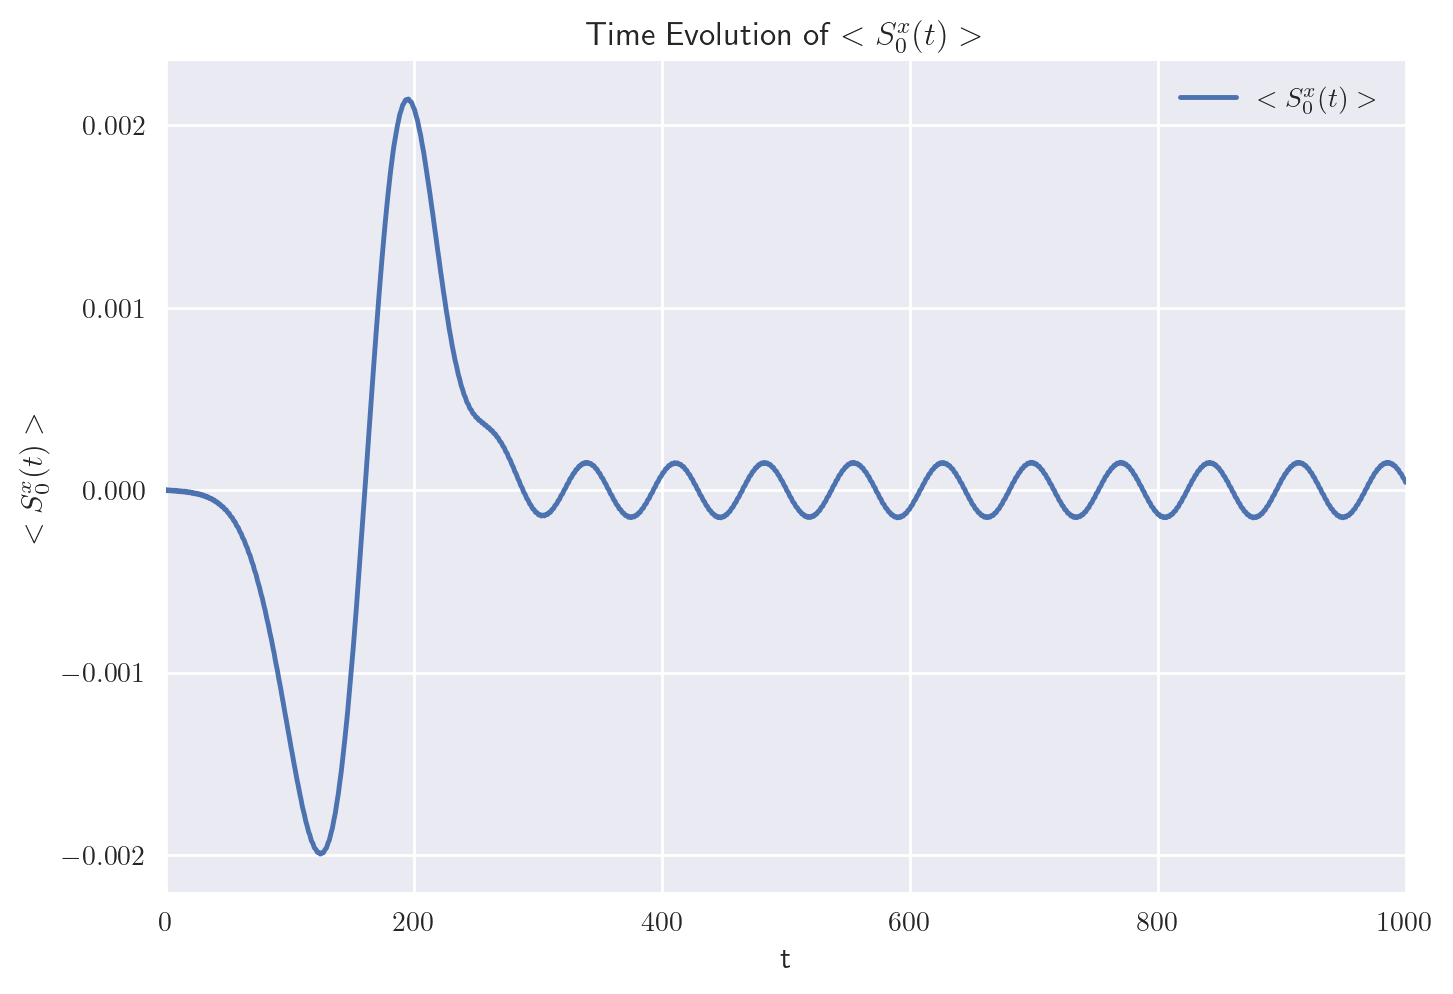

In [9]:
#qutip exact result with ground state as initial state
plt.plot(times, np.real(results), label = r'$<S_{0}^{x}(t)>$')

plt.title(r'Time Evolution of $<S_{0}^{x}(t)>$')
plt.ylabel(r'$<S_{0}^{x}(t)>$')
plt.xlabel("t")
plt.xlim(0,1000)
plt.legend()
plt.show()

In [10]:
# now let's write code for calculating linear response using rbm states
#we define necessary functions here
def batch_discrete_kernel(kernel):
    """
    Batch a kernel that only works with 1 sample so that it works with a
    batch of samples.
    Works only for discrete-kernels who take two args as inputs
    """

    def vmapped_kernel(logpsi_1, logpsi_2, pars1, pars2, σ, args):
        """
        local_value kernel for MCState and generic operators
        """
        σp, mels = args

        if jnp.ndim(σp) != 3:
            σp = σp.reshape((σ.shape[0], -1, σ.shape[-1]))
            mels = mels.reshape(σp.shape[:-1])

        vkernel = jax.vmap(kernel, in_axes=(None, None,None,None, 0, (0, 0)), out_axes=0)
        return vkernel(logpsi_1, logpsi_2, pars1, pars2, σ, (σp, mels))

    return vmapped_kernel

#we first need to estabalish the kernel functions for evaluating expectation values
@partial(jax.jit, static_argnums=(0, 1))
@batch_discrete_kernel
def corr_kernel(logpsi_1: Callable, logpsi_2: Callable, pars1: PyTree, pars2: PyTree, σ: Array, args: PyTree):
    σp, mel = args


    return jnp.sum(mel * jnp.exp(logpsi_1(pars1, σp) - logpsi_2(pars2, σ)))


def get_local_kernel_arguments(vstate: MCState, Ô: DiscreteOperator):  # noqa: F811
    check_hilbert(vstate.hilbert, Ô.hilbert)

    σ = vstate.samples
    σp, mels = Ô.get_conn_padded(σ)
    
    return σ, (σp, mels)

#here is the function for expectation value
#input: operator, left_psi (rbm object, parameter finalized), right_psi (rbm object, parameter finalized)
def expect(operator, left_psi, right_psi):
    para1 = right_psi.parameters
    para2 = left_psi.parameters
    
    logpsi_1 = right_psi._apply_fun
    logpsi_2 = left_psi._apply_fun
    
    model_state1 = right_psi.model_state
    model_state2 = left_psi.model_state
    
    σ, args = get_local_kernel_arguments(left_psi, operator)

    σ_shape = σ.shape
    if jnp.ndim(σ) != 2:
        σ = σ.reshape((-1, σ_shape[-1]))

    psi_loc = corr_kernel(
            logpsi_1,
            logpsi_2,
            {"params": para1, **model_state1},
            {"params": para2, **model_state2},
            σ,
            args,
        )

    psi = statistics(psi_loc)
    print("expectation done once")
    return psi.mean

# this modified version only works with S+, S- operators since it excludes the ground state contribution
def evo_corr(t_obver, obver, sta_list, eng_list, t_end, t_step, n_samples):
    num_step = int(np.around(t_end / t_step))
    time = []
    correlation = []
    initial_list = []
    
    #re-set the number of samples
    for ii in range(len(eng_list)):
        sta_list[ii].reset()
        sta_list[ii].n_samples = n_samples
    
    for j in range(len(eng_list)-1):
        initial_list.append(expect(t_obver, sta_list[0], sta_list[j+1]) * expect(obver, sta_list[j+1], sta_list[0]))
    
    for i in range(num_step+1):
        time.append(t_step*(i))
        corr_temp = complex(0,0)
        
        for j in range(len(eng_list)-1):
            op = np.exp(- 1j * (eng_list[j+1]-eng_list[0]) * t_step)
            initial_list[j] *= op
            corr_temp = sum(initial_list)


        correlation.append(corr_temp)
            
    return time, correlation